# Comparison Script for Our Algorithm and A pre_trained Deep neural network 

### Imports

In [ ]:
import os
from skimage import io, transform 
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize, thin
from skimage.io import imshow
import time
from utils import *
import tensorflow as tf 
from tensorflow import keras 
import cvzone
from cvzone.HandTrackingModule import HandDetector

## Utility Functions

In [2]:
def RGBtoYCbCr (R, G, B):
    R = int(R)
    G = int(G)
    B = int(B)
    R /= 255.0
    G /= 255.0
    B /= 255.0
    Y = 16 + (65.481 * R + 128.553 * G + 24.966 * B)
    Cb = 128 + (-37.797 * R - 74.203 * G + 112.0 * B)
    Cr = 128 + (112.0 * R - 93.786 * G - 18.214 * B)
    return Y, Cb, Cr

In [3]:
def our_model_train(path = './Skin_NonSkin.txt'):
    content = ""
    with open(path, 'r') as file:
        content = file.read()
    entries = content.split('\n')
    dataset = dict()
    for line in entries:
        if line:
            R, G, B, label = line.split()
            label = int(label)
            if(label not in dataset):
                dataset[label] = []
            Y, Cb, Cr = RGBtoYCbCr(R, G, B)
            dataset[label].append([Cb, Cr])
            
    return dataset

In [4]:
def get_mean_cov(dataset):
    mean = dict()
    cov = dict()
    for label in dataset:
        data = np.array(dataset[label])
        mean[label] = np.mean(data, axis=0)
        cov[label] = np.cov(data, rowvar=False)
    return mean, cov

In [5]:
def prob_c_label(C, mean, cov):
    C = np.array(C)
    mean = np.array(mean)
    cov = np.array(cov)
    
    C_diff = C - mean
    inv_cov = np.linalg.inv(cov)
    
    log_det = np.log(np.linalg.det(cov))
    
    log_norm_factor = 0.5 * (log_det + C.shape[1] * np.log(2 * np.pi))
    
    x = np.einsum('ijk,kl,ijl->ij', C_diff, inv_cov, C_diff)
    
    log_prob = -0.5 * x - log_norm_factor
    
    prob = np.exp(log_prob)
    
    return prob

In [6]:
def prob_skin_c(C, skin_mean, skin_cov, non_skin_mean, non_skin_cov):
    prob_c_skin = prob_c_label(C, skin_mean, skin_cov)
    prob_c_non_skin = prob_c_label(C, non_skin_mean, non_skin_cov)

    return prob_c_skin / (prob_c_skin + prob_c_non_skin)

In [7]:
def appendFaceContour(frame, resized_size, contour_areas, smallest_contours):
    original_height, original_width = frame.shape[:2]
    scale_x = resized_size[0] / original_width
    scale_y = resized_size[1] / original_height
    faces = face_cascade.detectMultiScale(frame, 1.3, 5)
    global max_face
    global max_area_face
    if len(faces) > 0:
        max_area = 0
        for (x, y, w, h) in faces:
            area = w * h
            if area > max_area and (max_area_face == 0 or abs(area - max_area_face) < 0.3 * max_area_face):
                max_area = area
                max_face = (x, y, w, h)
                max_area_face = max_area
    if max_face:
        (x, y, w, h) = max_face
        face = frame.copy()
        cv2.rectangle(face, (x, y), (x + w, y + h), (0, 255, 0), 2)
        radius = min(w, h) // 2 
        center_x = x + w // 2
        center_y = y + h // 2
        cv2.circle(face, (center_x, center_y), radius, (0, 255, 0), 2)
        cv2.imshow('face', face)
        x_resized = int(x * scale_x)
        y_resized = int(y * scale_y)
        w_resized = int(w * scale_x)
        h_resized = int(h * scale_y)
        middle_x = x_resized + w_resized // 2
        middle_y = y_resized + h_resized // 2
        for _, contour in contour_areas[-min(2,len(contour_areas)):]: 
            temp = contour.reshape(-1, 2)
            min_x = min(temp[:, 0])
            max_x = max(temp[:, 0])
            min_y = min(temp[:, 1])
            max_y = max(temp[:, 1])
            if (middle_x >= min_x and middle_x <= max_x) and (middle_y >= min_y and middle_y <= max_y):
                smallest_contours.append(contour)
    elif len(contour_areas) > 1:
        smallest_contours.append(contour_areas[-2][1])

In [8]:
def removeContours(mask, frame, resized_size):
    closed_mask = cv2.morphologyEx(mask, cv2.MORPH_DILATE, np.ones((20, 5)), iterations=3)
    contours = cv2.findContours(closed_mask.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
    contour_areas = [(cv2.contourArea(c), c) for c in contours]
    contour_areas.sort(key=lambda x: x[0]) 
    smallest_contours = [c[1] for c in contour_areas[:-min(2, len(contour_areas))]]
    ### can be removed
    if len(contour_areas) > 1 and contour_areas[-2][0] < contour_areas[-1][0] / 2:
        smallest_contours.append(contour_areas[-2][1])
    ### can be removed
    maybe_face = contour_areas[-min(2, len(contour_areas)):]
    
    appendFaceContour(frame, resized_size, maybe_face, smallest_contours)
    if len(smallest_contours) > 0:
        cv2.drawContours(mask, smallest_contours, -1, 0, -1)
    image = mask.copy()
    for x in contours[-min(2,len(contours)):]:
        cv2.drawContours(image, [x], -1, (0, 0, 255), 2)
    cv2.imshow('contours', image)


In [9]:
def cleanMask(skin_mask, frame, resized_size):
    binary_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_CLOSE, np.ones((3, 3)), iterations=3)
    binary_mask = cv2.threshold(binary_mask, 0.005, 1, cv2.THRESH_BINARY)[1]
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, np.ones((3, 3)), iterations=3)
    # binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, np.ones((3, 3)), iterations=3)
    removeContours(binary_mask, frame, resized_size)
    return binary_mask

In [10]:
def removeFaceMask(image, face_cascade):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    mask = np.ones((image.shape[0], image.shape[1]), dtype=np.uint8)
    
    Y, X = np.ogrid[:image.shape[0], :image.shape[1]]  # Create grid of indices
    for (x, y, w, h) in faces:
        center_x, center_y = x + w // 2, y + h // 2  
        radius = 1.1 * (max(w, h) // 2 ) 
        
        dist_from_center = (X - center_x)**2 + (Y - center_y)**2
        circular_mask = dist_from_center <= radius**2
        
        mask[circular_mask] = 0
    
    return mask

In [11]:
def select_color_from_fingertip(x, y):
    global drawing_color
    for (x1, y1, x2, y2), color in color_squares.items():
        if x1 <= x <= x2 and y1 <= y <= y2:
            drawing_color = color
            break

In [12]:
dataset = our_model_train()
mean, cov = get_mean_cov(dataset)
skin_mean = mean[1]
skin_cov = cov[1]
non_skin_mean = mean[2]
non_skin_cov = cov[2]
max_face = None
max_area_face = 0

drawing_color = (0, 0, 255)

color_squares = {
    (10, 10, 50, 50): (255, 0, 0), 
    (60, 10, 110, 50): (0, 255, 0), 
    (120, 10, 170, 50): (0, 0, 255), 
}

In [13]:
def import_data():
    train_img = [] 
    train_label = [] 
    test_img = [] 
    test_label = [] 
    i = 0
    # Debug single image from test directory
    test_dir = 'fingers/test'
    for f in os.listdir(test_dir):
        if f.endswith('.png'):  # Ensure only process image files
            i += 1
            if i > 200:
                break
            img = io.imread(os.path.join(test_dir, f))  # Use full path
            img = transform.resize(img, (480, 640), anti_aliasing=True)
            if len(img.shape) == 2:  # Grayscale image
                img = np.stack([img] * 3, axis=-1)
            test_img.append(img)
            test_label.append(f[-6])  # Extract label
            

    # Debug single image from train directory
    #train_dir = 'archive/fingers/train'
    #for f in os.listdir(train_dir):
    #    if f.endswith('.png'):  # Ensure only process image files
    #        img = io.imread(os.path.join(train_dir, f))  # Use full path
    #        img = transform.resize(img, (128, 128), anti_aliasing=True)
    #        train_img.append(img)
    #        
    #        train_label.append(f[-6])  # Extract label
            
            
    return np.array(test_img), np.array(test_label)


In [32]:
x_test, y_test = import_data()
y_test = np.copy(y_test.astype(int))

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 8192
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 8192
DEBUG:PIL.Image:Error closing: Operation on closed image
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 8192
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 8192
DEBUG:PIL.Image:Error closing: Operation on closed image
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 8192
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 8192
DEBUG:PIL.Image:Error closing: Operation on closed image
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 8192
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 8192
DEBUG:PIL.Image:Error closing: Operation on closed image
DEBUG:PIL.PngImagePl

In [ ]:
print(f"xtest: {x_test.shape}")
print(f"ytest: {y_test.shape}")

In [ ]:
print(y_test[0])

### Pre-trained NN

In [ ]:
detector = HandDetector(maxHands=1, detectionCon=0.8)

In [ ]:
def pre_trained_detection(img):
    if img.dtype != np.uint8:
        img_2 = np.copy((img * 255).astype(np.uint8))
    
    hands = detector.findHands(img_2, draw=False)  
    if hands:  
        hand = hands[0]
        if hand:    
            lmlist = hand[0]['lmList']
            fingerup = detector.fingersUp(hand[0])  
            finger_count = sum(fingerup)  
            return finger_count
        else:
            return 0

In [ ]:
correct = 0
for i in range(len(y_test)):
    finger_test = pre_trained_detection(x_test[i])
    if finger_test == y_test[i]:
        correct += 1
print(correct)

### Our Processing

In [40]:
def our_detection(frame):
    resizing_size_X = 512
    resizing_size_Y = 512
    resizing_size = (resizing_size_X, resizing_size_Y)
    #frame = cv2.flip(frame, 1)
    try:
        plt.imshow(frame)
        original = frame.copy()
        frame = frame.astype(np.uint8)
        frame = cv2.resize(frame, resizing_size)

        
     

        hand_mask = np.copy(frame)
        hand_mask = cv2.cvtColor(hand_mask, cv2.COLOR_BGR2GRAY)
        hand_mask = cv2.morphologyEx(hand_mask, cv2.MORPH_CLOSE, np.ones((3, 3)), iterations=3)
        if hand_mask.dtype != np.uint8:
            hand_mask = (hand_mask * 255).astype(np.uint8)
        try:
            finger_count = count_fingers(hand_mask)
        except:
            finger_count = 0

        return finger_count
        logger.info(f"Fingers detected: {finger_count}")
    except Exception as e:
        logger.error(f"Error during processing: {e}")
        return 0


In [33]:
x_test = (x_test * 255).astype(np.uint8)

(512, 512)
4


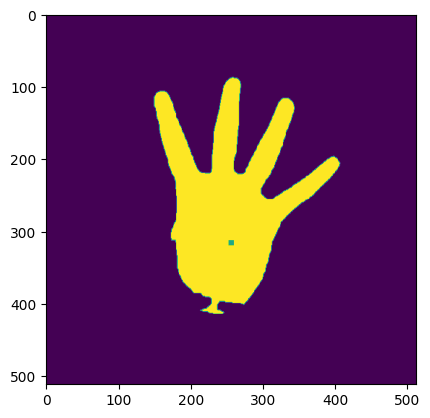

In [41]:

x = x_test[0].copy()
x = ((x > 100)).astype(np.uint8) * 255
# plt.imshow(x)
print(our_detection(x))
#finger_test = our_detection(x_test[0])
#if finger_test == y_test[0]:
#    correct += 1


(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)
(480, 640, 3)
(512, 512)


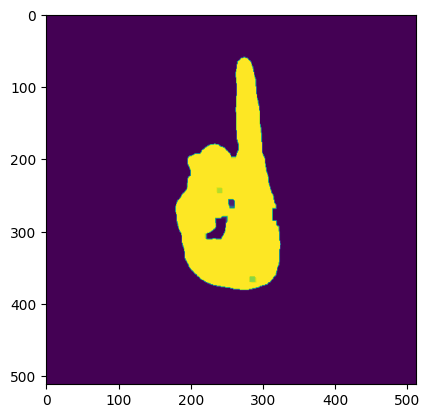

In [42]:
correct = 0
ind = []
for i in range(len(y_test)):
    
    print(x_test[i].shape)
    temp = np.copy(x_test[i])
    temp = ((temp > 100)).astype(np.uint8) * 255
    finger_test = our_detection(temp)
    if finger_test == y_test[i]:
        correct += 1
        ind.append(i)
print(correct)

In [ ]:
print(y_test[ind])

In [25]:
def main():
    our_fingers_count = our_detection()
    pre_trained_fingers_count = pre_trained_detection()
    if our_fingers_count == pre_trained_fingers_count:
        print("Right", our_fingers_count)

In [ ]:
if __name__ == "__main__":
    main()